In [1]:
import matplotlib.pyplot as plot
import numpy as np

import nixio as nix

In [2]:
nixf.close()

NameError: name 'nixf' is not defined

In [2]:
nixf = nix.File.open("module2x.h5", nix.FileMode.Overwrite)

In [3]:
b097 = nixf.create_block("joe097", "nix.session")
b108 = nixf.create_block("joe108", "nix.session")
b147 = nixf.create_block("joe147", "nix.session")
b151 = nixf.create_block("joe151", "nix.session")


Metadata

In [4]:
m_gen = nixf.create_section("General","odml.general")
m_gen.create_property("Experimenter", values_or_dtype='Alexa Riehle')
m_gen.create_property("Institution", values_or_dtype='CNRS, Marseille, France')
m_gen.create_property("RelatedPublications", values_or_dtype='doi: 10.1523/JNEUROSCI.5441-08.2009')

m_exp = nixf.create_section("Experiment","odml.experiment")
m_exp.create_property("Task", values_or_dtype='DelayedCenterOut')
m_subj = m_exp.create_section("Subject","odml.subject")
m_subj.create_property("Name", values_or_dtype='Joe')
m_subj.create_property("Species", values_or_dtype='Macaca mulatta')
m_subj.create_property("Sex", values_or_dtype='male')
m_rec = m_exp.create_section("Recording","odml.recording")
m_rec.create_property("BrainArea", values_or_dtype='M1')
m_rec.create_property("RecordingType", values_or_dtype='extracellular')
m_rec.create_property("SpikeSortingMethod", values_or_dtype='WindowDiscriminator')

# trial conditions:
condnames = {1 : "full", 2 : "2 of 6", 3 : "3 of 6"}
m_cond = m_exp.create_section("TrialConditions","odml.conditions")
def mkcond(cond, target):
    condname = "condition %d target %d" % (cond,target)
    sec = m_cond.create_section(condname, "odml.section")
    sec.create_property("BehavioralCondition", values_or_dtype=cond)
    sec.create_property("BehavioralConditionName", values_or_dtype=condnames[cond])
    sec.create_property("Target", values_or_dtype=target)

    return sec

m_infiles = {"joe097":"joe097-23457.gdf", "joe108":"joe108-124567.gdf", "joe147":"joe147-12467.gdf", "joe151":"joe151-12346.gdf"}
#m_mlfiles = {"joe097":"joe097-5-C3-MO.mat", "joe108":"joe108-4-C3-MO.mat", "joe147":"", "joe151":""}

m_conds = [[mkcond(c,t) for t in range(1,7) ] for c in range(1,4) ]

m_sess = nixf.create_section("Sessions","odml.section")
for sess in ["joe097", "joe108", "joe147", "joe151" ]:
    m_s1 = m_sess.create_section(sess,"odml.session")
    m_s1id = m_s1.create_property("SessionID", values_or_dtype=sess)
    m_s1infile = m_s1.create_property("InputFile", values_or_dtype=m_infiles[sess])
    m_s1subject = m_s1.create_section("Subject","odml.subject")
    m_s1subject.link = m_s1subject
    m_s1conds = m_s1.create_section("TrialConditions","odml.conditions")
    m_s1conds.link = m_cond


In [5]:
def mkunit(sblock,unitid):
    print(sblock.name)
    # create single unit
    su = sblock.create_source("Unit %d" % (unitid), "nix.ephys.unit")
    su.definition = "Single unit"
    # count trials as they appear
    trialcnt = 0
    # read all data
    for target in range(1, 7):
        # load spike matrix
        smxdata = np.loadtxt('asciidata/%s-%d-C3-MO_spikematrix_%02d.dat' % (sblock.name,unitid,target), dtype=int)
        # load motion end times
        medata = np.loadtxt('asciidata/%s-%d-C3-MO_MEevents_%02d.dat' % (sblock.name,unitid,target), dtype=float)
        medata = medata - 1000. # motion end time is stored as array index, so subtract the time offset
        # load trial start times
        tsdata = np.loadtxt('asciidata/%s-%d-C3-TS_MOevents_%02d.dat' % (sblock.name,unitid,target), dtype=float)
        tsdata = -tsdata # calculate trial start relative to motion from MO time in TS-aligned data
        # load spike times
        stf = open('asciidata/%s-%d-C3-MO_spiketrains_%02d.dat' % (sblock.name,unitid,target), 'r')
        stdata = []
        for line in stf:
            st = [int(i)-1000 for i in line.split()] # shift by -1000 ms for alignment to MO
            stdata.append(st)
        stf.close()
        #_for line
        #
        # data array of all trials with this target; time dim first, as in Jans data
        spikeactivity = sblock.create_data_array("SpikeActivity Unit %d Target %d" % (unitid,target),"nix.timeseries.binary",data=smxdata.T)
        spikeactivity.definition = "Array of spike occurrences aligned to movement onset (MO)"
        sa_dim1 = spikeactivity.append_sampled_dimension(1.) # 1 ms sampling interval
        sa_dim1.offset = -1000. # data aligned to MO
        sa_dim1.unit = "ms"
        sa_dim1.label = "time"
        sa_dim2 = spikeactivity.append_set_dimension() # trials
        sa_dim1.label = "trial"
        spikeactivity.sources.append(su)
        # mov tag
        # this is not so great because the need to define the positions an extents as dataarrays,
        # so stick to the movement epochs as tags for each trial
        #movtag = filter(lambda x: x.name == "Arm movement epochs for Target %d" % (target), sblock.multi_tags )
        #if not movtag:
        #    MOlst = sblock.create_data_array("MO times for Target %d" % (target), "nix.positions", data=[[0.0,tr] for tr in range(0,smxdata.shape[0])])
        #    MOdim1 = MOlst.append_sampled_dimension(1.)
        #    MOdim1.unit = "ms"
        #    MOdim1.label = "time"
        #    MOdim2 = MOlst.append_set_dimension()
        #    MOdim2.label = "trial"
        #    MElst = sblock.create_data_array("Movement durations for Target %d" % (target), "nix.positions", data=[[medata[tr],0] for tr in range(0,smxdata.shape[0])])
        #    MEdim1 = MElst.append_sampled_dimension(1.)
        #    MEdim1.unit = "ms"
        #    MEdim1.label = "time"
        #    MEdim2 = MElst.append_set_dimension()
        #    MEdim2.label = "trial"
        #    mov = sblock.create_multi_tag("Arm movement epochs for Target %d" % (target), "nix.epoch", MOlst)
        #    mov.definition = "Epochs between detected movement onset (MO) and movement end (ME)"
        #    mov.extents = MElst
        #    mov.units = ["ms",]
        #else:
        #    mov = movtag[0]
        #mov.references.append(spikeactivity)
        #~~~~
        # loop over all trials for this target
        for tr in range(0,smxdata.shape[0]):
            trialcnt += 1
            #spikeactivity = sblock.create_data_array("SpikeActivity Unit %d Trial %03d" % (unitid,trialcnt),"nix.timeseries.binary",data=smxdata[tr])
            #spikeactivity.definition = "Array of spike occurrences aligned to movement onset (MO)" 
            #sa_dim.offset = -1000. # data aligned to MO
            #sa_dim.unit = "ms"
            #sa_dim.label = "time"
            # array of spike times
            spiketimes = sblock.create_data_array("SpikeTimes Unit %d Trial %03d" % (unitid,trialcnt),"nix.spiketimes",data=stdata[tr])
            spiketimes.definition = "Spike times aligned to movement onset (MO)"
            spiketimes.append_set_dimension()
            spiketimes.unit = "ms"
            spiketimes.label = "spikes"
            # spike train as multitag
            #spikepos = [[x,tr] for x in stdata[tr]]
            #spiketrain = sblock.create_multi_tag("Spiketrain Unit %d Trial %03d" % (unitid,trialcnt), "nix.spiketrain",spikepos)
            #spiketrain.definition = "Spike times aligned to movement onset (MO)"
            #spiketrain.references.append(spikeactivity)
            # assign sources
            spiketimes.sources.append(su)
            #spiketrain.sources.append(su)
            # assign metadata
            spikeactivity.metadata = m_conds[2][target-1] # so far all data are 'C3' -> index 2 in conds
            spiketimes.metadata = m_conds[2][target-1]
            # trial as tag
            trialtag = list(filter(lambda x: x.name == "Trial %03d" % (trialcnt), sblock.tags ))
            if not trialtag:
                trial = sblock.create_tag("Trial %03d" % (trialcnt), "nix.trial",[tsdata[tr],tr])
                trial.definition = "Trial start (TS) relative to motion onset (MO)"
                trial.extent = [3000.,0] # trial length of 3000ms is arbitrary
                trial.units = ["ms"]
                trial.metadata = m_conds[2][target-1]
            else:
                trial = trialtag[0]
            
            trial.references.append(spikeactivity)
            # arm movement period as tag
            movtag = list(filter(lambda x: x.name == "Arm movement epoch Trial %03d" % (trialcnt), sblock.tags ))
            if not movtag:
                mov = sblock.create_tag("Arm movement epoch Trial %03d" % (trialcnt), "nix.epoch",[0.0,tr])
                mov.definition = "Epoch between detected movement onset (MO) and movement end (ME)"
                mov.extent = [medata[tr],0] # because motion onset is at 0.0, duration is equal to end time
                mov.units = ["ms",]
            else:
                mov = movtag[0]
            mov.references.append(spikeactivity)
        #_for tr
    #_for target
#_def mkunit


In [6]:
mkunit(b097, 5)
mkunit(b108, 4)
mkunit(b108, 7)
mkunit(b147, 1)
mkunit(b151, 1)


joe097
joe108
joe108
joe147
joe151


In [7]:
nixf.close()

read data from file

In [8]:
nixf = nix.File.open("module2x.h5", nix.FileMode.ReadOnly)

In [9]:
nixf.blocks

[Block: {name = joe097, type = nix.session}, Block: {name = joe108, type = nix.session}, Block: {name = joe147, type = nix.session}, Block: {name = joe151, type = nix.session}]

get overview of file contents

In [10]:
for b in nixf.blocks:
    tlst = list(filter( lambda x : x.type == "nix.trial", b.tags))
    print('%s: %d trials' % (b.name,len(tlst)))
    for s in b.sources:
        print('\t%s ' % s.name)


joe097: 99 trials
	Unit 5 
joe108: 121 trials
	Unit 4 
	Unit 7 
joe147: 120 trials
	Unit 1 
joe151: 119 trials
	Unit 1 


select some data from one of the blocks

In [11]:
b108 = nixf.blocks["joe108"]

In [12]:
b108.sources

[Source: {name = Unit 4, type = nix.ephys.unit}, Source: {name = Unit 7, type = nix.ephys.unit}]

In [13]:
dalst = filter(lambda x: 
               ("SpikeActivity" in x.name) &
               (filter(lambda s: s.name == "Unit 7", x.sources) != []) & 
               (x.metadata['Target'] == 2) & 
               (x.metadata['BehavioralCondition'] == 3),
               b108.data_arrays)
dalst = list(dalst)

In [14]:
print(dalst)

[DataArray: {name = SpikeActivity Unit 4 Target 2, type = nix.timeseries.binary}, DataArray: {name = SpikeActivity Unit 7 Target 2, type = nix.timeseries.binary}]


In [15]:
len(dalst)

2

In [16]:
dalst[0].shape

(2000, 18)

In [17]:
spikedata = dalst[0]

In [18]:
spikedata.shape

(2000, 18)

In [19]:
yyy = np.nonzero(spikedata)

In [20]:
[tind,jind] = np.nonzero(spikedata)

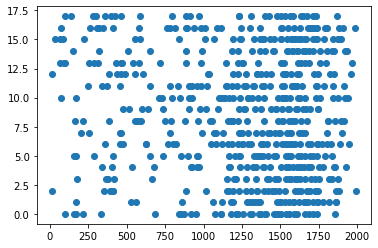

In [21]:
plot.scatter(tind, jind)

In [22]:
[jbla, tbla] = np.nonzero(np.array(spikedata).T)

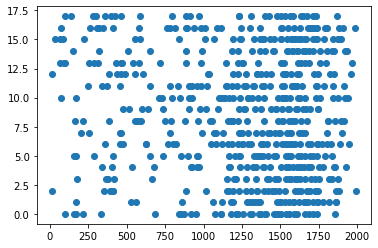

In [23]:
plot.scatter(tbla, jbla)

In [24]:
nixf.close()